<a href="https://colab.research.google.com/github/apragill/github-slideshow/blob/master/New_York_Stock_Exchange_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predicting the stock market values.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_validate


from datetime import datetime as dt

from sklearn.cluster import KMeans

In [ ]:
prices_url = "https://github.com/cschatz/data150/blob/master/prices-split-adjusted.csv.zip?raw=true"
df1 = pd.read_csv(prices_url, compression="zip")

fundamentals_url = "https://github.com/cschatz/data150/blob/master/fundamentals.csv.zip?raw=true"
df2 = pd.read_csv(fundamentals_url, compression="zip").drop("Unnamed: 0", axis=1)

securities_url = "https://raw.githubusercontent.com/cschatz/data150/master/securities.csv"
df3 = pd.read_csv(securities_url)

prices = df1.merge(df3, left_on="symbol", right_on="Ticker symbol", 
                suffixes=(False, False), validate="m:1").drop("Ticker symbol", axis=1)

fundamentals = df2.merge(df3, left_on="Ticker Symbol", right_on="Ticker symbol", 
                suffixes=(False, False), validate="m:1").drop("Ticker symbol", axis=1).rename({"Ticker Symbol": "symbol"})

In [ ]:
fundamentals.head(8)

,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,Cost of Revenue,Current Ratio,Deferred Asset Charges,Deferred Liability Charges,Depreciation,Earnings Before Interest and Tax,Earnings Before Tax,Effect of Exchange Rate,Equity Earnings/Loss Unconsolidated Subsidiary,Fixed Assets,Goodwill,Gross Margin,Gross Profit,Income Tax,Intangible Assets,Interest Expense,Inventory,Investments,Liabilities,Long-Term Debt,Long-Term Investments,Minority Interest,Misc. Stocks,Net Borrowings,Net Cash Flow,Net Cash Flow-Operating,Net Cash Flows-Financing,Net Cash Flows-Investing,...,Non-Recurring Items,Operating Income,Operating Margin,Other Assets,Other Current Assets,Other Current Liabilities,Other Equity,Other Financing Activities,Other Investing Activities,Other Liabilities,Other Operating Activities,Other Operating Items,Pre-Tax Margin,Pre-Tax ROE,Profit Margin,Quick Ratio,Research and Development,Retained Earnings,Sale and Purchase of Stock,"Sales, General and Admin.",Short-Term Debt / Current Portion of Long-Term Debt,Short-Term Investments,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,0.0,127000000.0,1.049900e+10,78.0,0.000000e+00,223000000.0,1.001000e+09,-1.813000e+09,-2.445000e+09,0.0,0.0,1.340200e+10,0.000000e+00,58.0,1.435600e+10,-5.690000e+08,8.690000e+08,632000000.0,5.800000e+08,3.060000e+08,4.730000e+08,7.116000e+09,0.0,0.0,0.0,-1.020000e+09,1.970000e+08,1.285000e+09,4.830000e+08,-1.571000e+09,...,3.860000e+08,1.480000e+08,1.0,2.167000e+09,6.260000e+08,4.524000e+09,-2.980000e+09,1.509000e+09,1.100000e+07,1.514700e+10,-141000000.0,8.450000e+08,10.0,31.0,8.0,72.0,0.0,-9.462000e+09,0.000000e+00,1.297700e+10,1.419000e+09,3.412000e+09,2.351000e+10,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08,American Airlines Group,reports,Industrials,Airlines,"Fort Worth, Texas",2015-03-23,6201
1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,0.0,5000000.0,1.101900e+10,104.0,0.000000e+00,935000000.0,1.020000e+09,-1.324000e+09,-2.180000e+09,0.0,0.0,1.925900e+10,4.086000e+09,59.0,1.572400e+10,-3.460000e+08,2.311000e+09,856000000.0,1.012000e+09,-1.181000e+09,-2.350000e+08,1.535300e+10,0.0,0.0,0.0,2.208000e+09,6.600000e+08,6.750000e+08,3.799000e+09,-3.814000e+09,...,5.590000e+08,1.399000e+09,5.0,2.299000e+09,1.465000e+09,7.385000e+09,-2.032000e+09,1.711000e+09,4.810000e+08,1.491500e+10,-56000000.0,8.530000e+08,8.0,80.0,7.0,96.0,0.0,-1.129600e+10,0.000000e+00,1.291300e+10,1.446000e+09,8.111000e+09,4.227800e+10,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08,American Airlines Group,reports,Industrials,Airlines,"Fort Worth, Texas",2015-03-23,6201
2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,0.0,7000000.0,1.562000e+10,88.0,0.000000e+00,829000000.0,1.342000e+09,4.099000e+09,3.212000e+09,0.0,0.0,2.308400e+10,4.091000e+09,63.0,2.703000e+10,3.300000e+08,2.240000e+09,887000000.0,1.004000e+09,1.799000e+09,-1.026000e+09,1.604300e+10,0.0,0.0,0.0,1.700000e+08,-1.460000e+08,3.080000e+09,-3.150000e+08,-2.911000e+09,...,8.000000e+08,4.249000e+09,10.0,2.060000e+09,8.980000e+08,7.059000e+09,-4.559000e+09,8.170000e+08,6.010000e+08,1.092800e+10,-500000000.0,1.295000e+09,8.0,159.0,7.0,80.0,0.0,-8.562000e+09,-1.052000e+09,2.068600e+10,1.677000e+09,6.309000e+09,4.322500e+10,1.175000e+10,1.340400e+10,2.021000e+

In [ ]:
fundamentals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1781 entries, 0 to 1780
Data columns (total 85 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Ticker Symbol                                        1781 non-null   object 
 1   Period Ending                                        1781 non-null   object 
 2   Accounts Payable                                     1781 non-null   float64
 3   Accounts Receivable                                  1781 non-null   float64
 4   Add'l income/expense items                           1781 non-null   float64
 5   After Tax ROE                                        1781 non-null   float64
 6   Capital Expenditures                                 1781 non-null   float64
 7   Capital Surplus                                      1781 non-null   float64
 8   Cash Ratio                                           1482 non-null  

In [ ]:
len(fundamentals["Ticker Symbol"].unique())

448

Within the fundamentals data set there are at least 84 different columns with data, with 448 symbols for Ticker Symbols. 

In [ ]:
fundamentals.isnull().sum()

Ticker Symbol                   0
Period Ending                   0
Accounts Payable                0
Accounts Receivable             0
Add'l income/expense items      0
                             ... 
GICS Sector                     0
GICS Sub Industry               0
Address of Headquarters         0
Date first added              697
CIK                             0
Length: 85, dtype: int64

The only missing entery's in this dataset we're in "Date first added". This could mean that many companies may not have numbers when came into the stock market

In [ ]:
fundamentals.groupby("GICS Sector")["Total Revenue"].mean()

GICS Sector
Consumer Discretionary         1.805898e+10
Consumer Staples               4.340793e+10
Energy                         3.898480e+10
Financials                     1.877966e+10
Health Care                    2.314222e+10
Industrials                    1.654767e+10
Information Technology         1.561791e+10
Materials                      1.183452e+10
Real Estate                    2.474288e+09
Telecommunications Services    5.753739e+10
Utilities                      1.113568e+10
Name: Total Revenue, dtype: float64

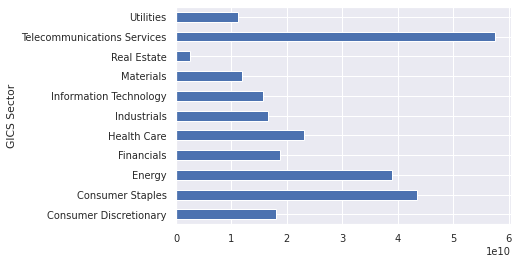

In [ ]:
fundamentals.groupby("GICS Sector")["Total Revenue"].mean().plot.barh()

 Here we found the average Total Revenue from each sector in the stock market. It is easier to see on the graph that Telecommunications Services has the highest average of Total Revenue.

In [ ]:
index = fundamentals["Total Revenue"].idxmax()
fundamentals.iloc[index]

Ticker Symbol                                          WMT
Period Ending                                   2015-01-31
Accounts Payable                                5.8583e+10
Accounts Receivable                              -5.69e+08
Add'l income/expense items                        1.13e+08
                                          ...             
GICS Sector                               Consumer Staples
GICS Sub Industry             Hypermarkets & Super Centers
Address of Headquarters              Bentonville, Arkansas
Date first added                                1982-08-31
CIK                                                 104169
Name: 1708, Length: 85, dtype: object

Ticker Symbol WMT (Walmart) had the highest Total Revenue. This shows the exact period ending date and all the information relating of Walmart.

In [ ]:
wmt = fundamentals[fundamentals['Ticker Symbol']=='WMT']
wmt.head()

,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,Changes in Inventories,Common Stocks,Cost of Revenue,Current Ratio,Deferred Asset Charges,Deferred Liability Charges,Depreciation,Earnings Before Interest and Tax,Earnings Before Tax,Effect of Exchange Rate,Equity Earnings/Loss Unconsolidated Subsidiary,Fixed Assets,Goodwill,Gross Margin,Gross Profit,Income Tax,Intangible Assets,Interest Expense,Inventory,Investments,Liabilities,Long-Term Debt,Long-Term Investments,Minority Interest,Misc. Stocks,Net Borrowings,Net Cash Flow,Net Cash Flow-Operating,Net Cash Flows-Financing,Net Cash Flows-Investing,...,Non-Recurring Items,Operating Income,Operating Margin,Other Assets,Other Current Assets,Other Current Liabilities,Other Equity,Other Financing Activities,Other Investing Activities,Other Liabilities,Other Operating Activities,Other Operating Items,Pre-Tax Margin,Pre-Tax ROE,Profit Margin,Quick Ratio,Research and Development,Retained Earnings,Sale and Purchase of Stock,"Sales, General and Admin.",Short-Term Debt / Current Portion of Long-Term Debt,Short-Term Investments,Total Assets,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
1706,WMT,2013-01-31,5.909900e+10,-614000000.0,186000000.0,22.0,-1.289800e+10,3.620000e+09,11.0,7.781000e+09,-2.759000e+09,332000000.0,3.522970e+11,83.0,0.0,7.613000e+09,8.478000e+09,2.791100e+10,2.566200e+10,2.230000e+08,0.0,1.166810e+11,2.049700e+10,25.0,1.163540e+11,7.958000e+09,0.0,2.249000e+09,4.380300e+10,0.0,2.313000e+09,4.141700e+10,0.0,5.395000e+09,5.190000e+08,1.487000e+09,1.231000e+09,2.559100e+10,-1.194600e+10,-1.263700e+10,...,0.0,2.772500e+10,6.0,5.987000e+09,1.588000e+09,0.0,-5.870000e+08,-58000000.0,2.610000e+08,0.0,0.0,0.0,5.0,34.0,4.0,22.0,0.0,7.297800e+10,-7.732000e+09,8.862900e+10,1.271900e+10,0.0,2.031050e+11,5.994000e+10,7.181800e+10,7.634300e+10,1.267620e+11,2.031050e+11,4.686510e+11,0.0,2013.0,5.04,3.372817e+09,Wal-Mart Stores,reports,Consumer Staples,Hypermarkets & Super Centers,"Bentonville, Arkansas",1982-08-31,104169
1707,WMT,2014-01-31,5.717400e+10,-566000000.0,119000000.0,21.0,-1.311500e+10,2.362000e+09,10.0,7.281000e+09,-1.667000e+09,323000000.0,3.580690e+11,88.0,0.0,8.017000e+09,8.870000e+09,2.699100e+10,2.465600e+10,-4.420000e+08,0.0,1.179070e+11,1.951000e+10,25.0,1.182250e+11,8.105000e+09,0.0,2.335000e+09,4.485800e+10,0.0,-5.900000e+08,4.455900e+10,0.0,5.084000e+09,1.491000e+09,3.015000e+09,-5.000000e+08,2.325700e+10,-1.078900e+10,-1.252600e+10,...,0.0,2.687200e+10,6.0,6.149000e+09,2.369000e+09,89000000.0,-2.996000e+09,-260000000.0,5.890000e+08,0.0,0.0,0.0,5.0,32.0,3.0,24.0,0.0,7.656600e+10,-6.979000e+09,9.135300e+10,1.208200e+10,0.0,2.047510e+11,6.118500e+10,6.934500e+10,7.625500e+10,1.284960e+11,2.047510e+11,4.762940e+11,0.0,2014.0,4.90,3.269796e+09,Wal-Mart Stores,reports,Consumer Staples,Hypermarkets & Super Centers,"Bentonville, Arkansas",1982-08-31,104169
1708,WMT,2015-01-31,5.858300e+10,-569000000.0,113000000.0,20.0,-1.217400e+10,2.462000e+09,14.0,9.135000e+09,-1.229000e+09,323000000.0,3.650860e+11,97.0,0.0,8.805000e+09,9.173000e+09,2.726000e+10,2.479900e+10,-5.140000e+08,0.0,1.166550e+11,1.810200e+10,25.0,1.205650e+11,7.985000e+09,0.0,2.461000e+09,4.514100e+10,0.0,4.093000e+09,4.349500e+10,0.0,4.543000e+09,0.000000e+00,-5.018000e+09,1.854000e+09,2.856400e+10,-1.507100e+10,-1.112500e+10,...,0.0,2.714700e+10,6.0,5.455000e+09,2.224000e+09,0.0,-7.168000e+09,-409000000.0,1.049000e+09,0.0,0.0,0.0,5.0,30.0,3.0,28.0,0.0,8.577700e+10,-2.859000e+09,9.341800e+10,6.670000e+09,0.0,2.034900e+11,6.327800e+10,6.525300e+10,8.139400e+10,1.220960e+11,2.034900e+11,4.856510e+11,0.0,2015.0,5.07,3.227416e+09,Wal-Mart Stores,re

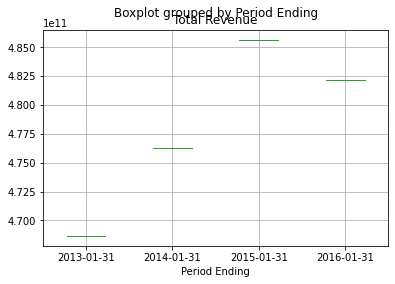

In [ ]:
wmt.boxplot("Total Revenue", by="Period Ending")
plt.show()

This box plot gives us data for ending periods from 2013-2016. Each year's ending period was on January 31st. Showing us that the highest Total Revnue what in 2015 and the lowest revenue was in 2013. 

Now we are just looking at data for specifically for Walmart from the fundamentals data set. 

In [ ]:
corr = wmt.corr()["Total Revenue"]
cond = corr < 1.0
corr[cond].abs().sort_values().tail(50)

Operating Margin                                       0.354111
Accounts Receivable                                    0.411371
Liabilities                                            0.471793
Operating Income                                       0.473149
Earnings Before Interest and Tax                       0.485673
Deferred Liability Charges                             0.486571
Misc. Stocks                                           0.495048
Other Assets                                           0.511722
Earnings Before Tax                                    0.521380
Net Income Applicable to Common Shareholders           0.553953
Net Income                                             0.553953
Net Income-Cont. Operations                            0.610413
Long-Term Debt                                         0.648842
Minority Interest                                      0.650133
Net Cash Flow-Operating                                0.653871
Capital Expenditures                    

From the 84 different columns, I am looking at the first 50 columns that are correlated to Total Revnue. It lists all the values from lowest to highest correlation to Total Revenue.

In [ ]:
prices.head(8)

,date,symbol,open,close,low,high,volume,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,Willis Towers Watson,reports,Financials,Insurance Brokers,"London, United Kingdom",2016-01-05,1140536
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,Willis Towers Watson,reports,Financials,Insurance Brokers,"London, United Kingdom",2016-01-05,1140536
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,Willis Towers Watson,reports,Financials,Insurance Brokers,"London, United Kingdom",2016-01-05,1140536
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,Willis Towers Watson,reports,Financials,Insurance Brokers,"London, United Kingdom",2016-01-05,1140536
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,Willis Towers Watson,reports,Financials,Insurance Brokers,"London, United Kingdom",2016-01-05,1140536
5,2016-01-12,WLTW,115.510002,115.550003,114.500000,116.059998,1098000.0,Willis Towers Watson,reports,Financials,Insurance Brokers,"London, United Kingdom",2016-01-05,1140536
6,2016-01-13,WLTW,116.459999,112.849998,112.589996,117.070000,949600.0,Willis Towers Watson,reports,Financials,Insurance Brokers,"London, United Kingdom",2016-01-05,1140536
7,2016-01-14,WLTW,113.510002,114.379997,110.050003,115.029999,785300.0,Willis Towers Watson,reports,Financials,Insurance Brokers,"London, United Kingdom",2016-01-05,1140536


In [ ]:
prices.isnull().sum()

date                            0
symbol                          0
open                            0
close                           0
low                             0
high                            0
volume                          0
Security                        0
SEC filings                     0
GICS Sector                     0
GICS Sub Industry               0
Address of Headquarters         0
Date first added           345737
CIK                             0
dtype: int64

The only missing enteries for Date First Added. Which are entries from when they we're first added into the stock market.

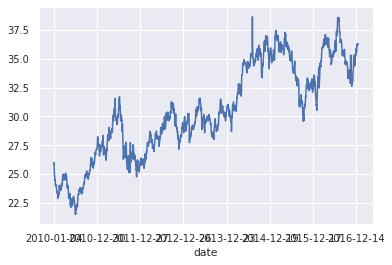

In [ ]:
cond = prices["GICS Sector"] == "Telecommunications Services"
prices[cond].groupby("date")["high"].mean().plot()

From the average highest "Total Revenue" in GICS Sector Telecommunitcations Services, you can see the high for each day in the graph. 

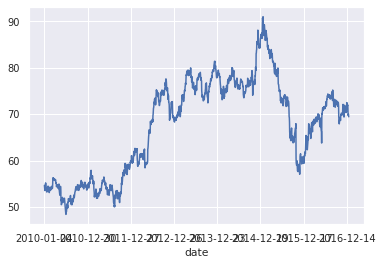

In [ ]:
cond2 = prices["symbol"] == "WMT"
prices[cond2].groupby("date")["high"].mean().plot()

Now looking at the average high for the Walmart stock, we see a huge drop within 2012 and eventually going up in the later years. Although it is a bit hard to read the dates on the bottom it shows that around 2014 adn 2015 it stock was at its highest just like in previous graph in fundamentals data set.

In [ ]:
df = prices.loc[prices["symbol"]== "WMT"]
df.drop("symbol", axis = 1, inplace=True)
print(np.shape(df))
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

df.head()

(1762, 13)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,open,close,low,high,volume,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
date,,,,,,,,,,,,
2010-01-04,53.740002,54.230000,53.669998,54.669998,20753100.0,Wal-Mart Stores,reports,Consumer Staples,Hypermarkets & Super Centers,"Bentonville, Arkansas",1982-08-31,104169
2010-01-05,54.090000,53.689999,53.570000,54.189999,15648400.0,Wal-Mart Stores,reports,Consumer Staples,Hypermarkets & Super Centers,"Bentonville, Arkansas",1982-08-31,104169
2010-01-06,53.500000,53.570000,53.419998,53.830002,12517200.0,Wal-Mart Stores,reports,Consumer Staples,Hypermarkets & Super Centers,"Bentonville, Arkansas",1982-08-31,104169
2010-01-07,53.720001,53.599998,53.259998,53.750000,10662700.0,Wal-Mart Stores,reports,Consumer Staples,Hypermarkets & Super Centers,"Bentonville, Arkansas",1982-08-31,104169
2010-01-08,53.430000,53.330002,53.020000,53.529999,11363200.0,Wal-Mart Stores,reports,Consumer Staples,Hypermarkets & Super Centers,"Bentonville, Arkansas",1982-08-31,104169


We can take out all the data for Walmart and shifting the dates to the in the index for. Now each date correlates to the exact column. Dates start from January of 2010 going all the way down to 2016.

In [ ]:
df.isnull().sum()

open                       0
close                      0
low                        0
high                       0
volume                     0
Security                   0
SEC filings                0
GICS Sector                0
GICS Sub Industry          0
Address of Headquarters    0
Date first added           0
CIK                        0
dtype: int64

There are no missing entries in the data set. 

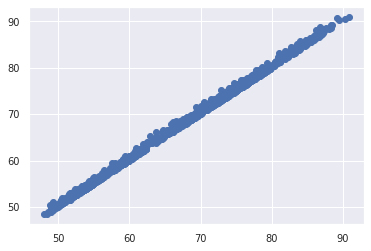

In [ ]:
plt.scatter(df["open"], df["high"])

In this graph you can see that there is not a major different between the opening and high stock values. 

In [ ]:
Max_date = df.index.max()
print(Max_date)
Min_date = df.index.min()
print(Min_date)
print (Max_date - Min_date)

2016-12-30 00:00:00
2010-01-04 00:00:00
2552 days 00:00:00


Highest and lowest dates in the entire data set. 2552 days apart from each other. 

In [ ]:
df2 = df[["close"]]
print(df2)

                close
date                 
2010-01-04  54.230000
2010-01-05  53.689999
2010-01-06  53.570000
2010-01-07  53.599998
2010-01-08  53.330002
...               ...
2016-12-23  69.540001
2016-12-27  69.699997
2016-12-28  69.309998
2016-12-29  69.260002
2016-12-30  69.120003

[1762 rows x 1 columns]


Creating a new data set that allows us to look at the date and the closing price of the Walmart stock. This data set will be used to predict the stock forecast. 

In [ ]:
forecast = int(31) 
df2['Prediction'] = df2[["close"]].shift(-forecast)
print(df.tail())
df2['Prediction']

                 open      close  ...  Date first added     CIK
date                              ...                          
2016-12-23  69.430000  69.540001  ...        1982-08-31  104169
2016-12-27  69.300003  69.699997  ...        1982-08-31  104169
2016-12-28  69.940002  69.309998  ...        1982-08-31  104169
2016-12-29  69.209999  69.260002  ...        1982-08-31  104169
2016-12-30  69.120003  69.120003  ...        1982-08-31  104169

[5 rows x 12 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


date
2010-01-04    53.470001
2010-01-05    53.490002
2010-01-06    53.830002
2010-01-07    53.619999
2010-01-08    53.919998
                ...    
2016-12-23          NaN
2016-12-27          NaN
2016-12-28          NaN
2016-12-29          NaN
2016-12-30          NaN
Name: Prediction, Length: 1762, dtype: float64

You can now see that new data frame that will be used to predict the stock. As you can see there are no values for the days we will be predicting starting from 2016-12-23

In [ ]:
X = np.array(df2.drop(["Prediction"], 1))
X = preprocessing.scale(X)
X_forecast = X[-forecast:]
X = X[:-forecast] 
y = np.array(df2["Prediction"])
y = y[:-forecast]

X

array([[-1.24718367],
       [-1.29977263],
       [-1.31145895],
       ...,
       [ 0.40839193],
       [ 0.33632522],
       [ 0.42689493]])

We are now setting up the x and y values to predict the next 30 days of forecast. The y values will be used to set our prediction values, while the x will create a new array. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

Using the train test split here will allow us to get a r^2 value that will be used for our linear regression to predicts the forecast for the next 30 days. 

In [ ]:
linear = LinearRegression()
linear.fit(X_train,y_train)
value = linear.score(X_test, y_test)
print("value: ", value)

value:  0.8813962508936883


This given value will allow us to predict the forecast values for Walmart stock. 

In [ ]:
forecast = linear.predict(X_forecast)
print(forecast)

[71.30415462 69.27765732 68.67891774 69.44346279 70.13431508 70.788321
 71.15677648 71.1199301  71.28573557 70.4198646  70.64093549 70.83437321
 69.96850961 70.35538598 70.57645595 70.33695864 70.09746871 71.56207188
 71.68182422 71.25809503 71.0186051  70.92649238 71.47917329 71.70024419
 71.16598324 69.64610635 69.60005414 69.74743227 69.38819    69.34213687
 69.21317869]


These are the predicted values forecasted for the next 30 days for the Walmart stock. They fluctuates between 69-71 throughout the 30 days. 

In [ ]:
stocknumbers = pd.DataFrame([69.32703585, 68.72031489, 69.49505156, 70.19511313, 70.85783715, 71.23120426,71.19386671, 
                             71.36188242, 70.48446912, 70.70848695, 70.90450326, 70.02709742, 70.41913097, 70.64314787, 
                             70.40045799, 70.15777558, 71.64190238, 71.76325105, 71.33387342, 71.09119101, 70.9978504, 
                             71.55789872, 71.78191656, 71.24053374, 69.70039642, 69.65373032, 69.80307305, 69.43904197, 
                             69.39237493, 69.26169771],columns=['30 Day WMT Stock Forecast'])
print (stocknumbers)

    30 Day WMT Stock Forecast
0                   69.327036
1                   68.720315
2                   69.495052
3                   70.195113
4                   70.857837
5                   71.231204
6                   71.193867
7                   71.361882
8                   70.484469
9                   70.708487
10                  70.904503
11                  70.027097
12                  70.419131
13                  70.643148
14                  70.400458
15                  70.157776
16                  71.641902
17                  71.763251
18                  71.333873
19                  71.091191
20                  70.997850
21                  71.557899
22                  71.781917
23                  71.240534
24                  69.700396
25                  69.653730
26                  69.803073
27                  69.439042
28                  69.392375
29                  69.261698


Shows all data in a column from day 0 to day 29 of the predicted Walmart stock values